# Import File

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
TEST_SIZE = 0.8

In [76]:
data_path = 'data/hdb_latest.csv'

In [77]:
df_combined_geo = pd.read_csv(data_path)

C:\Users\Randy\AppData\Local\Temp\ipykernel_12820\2287234153.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined_geo = pd.read_csv(data_path)


## Feature Engineering

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
# we can drop id and lease commence date 
# lease commence date since the feature is already present in remaining lease

In [80]:
# make a copy first
df_original = df_combined_geo.copy()

In [81]:
train_df, test_df = train_test_split(df_combined_geo, test_size=TEST_SIZE, random_state=SEED)

In [82]:
train_df.columns

Index(['town', 'flat_type', 'flat_model', 'floor_area_sqm', 'street_name',
       'resale_price', 'month', 'lease_commence_date', 'storey_range', 'block',
       'remaining_lease', 'address', 'full_address', 'lat', 'long',
       'nearest_mrt', 'nearest_distance_to_mrt'],
      dtype='object')

In [83]:
train_df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
76365,JURONG EAST,4 ROOM,New Generation,103.0,TEBAN GDNS RD,395000.0,2021-03,1981,10 TO 12,31,59 years 04 months,31 TEBAN GDNS RD,31 TEBAN GARDENS ROAD SINGAPORE 600031,1.320308,103.738968,jurong east,1.475
473179,HOUGANG,5 ROOM,Improved,121.0,HOUGANG AVE 9,265000.0,2006-09,1999,01 TO 03,964,92,964 HOUGANG AVE 9,964 HOUGANG AVENUE 9 SINGAPORE 530964,1.377158,103.877524,tongkang,1.641
445613,WOODLANDS,4 ROOM,Model A,101.0,WOODLANDS RING RD,208000.0,2002-07,1998,07 TO 09,644,95,644 WOODLANDS RING RD,644 WOODLANDS RING ROAD SINGAPORE 730644,1.436909,103.801599,admiralty,0.415
817033,WOODLANDS,EXECUTIVE,MAISONETTE,146.0,WOODLANDS ST 81,430000.0,1998-04,1988,04 TO 06,804,89,804 WOODLANDS ST 81,804 WOODLANDS STREET 81 SINGAPORE 730804,1.439970,103.787772,woodlands,0.398
277677,YISHUN,3 ROOM,Model A,74.0,YISHUN RING RD,223000.0,2009-09,1983,07 TO 09,115,73,115 YISHUN RING RD,115 YISHUN RING ROAD CHONG PANG VALE SINGAPORE...,1.434565,103.827974,canberra,0.966


In [84]:
# Lease commence date has already been processed with current date.
# Address is a combination of block and street name. The Full address is retrieved from onemap sg using address.
train_df.drop(columns=['lease_commence_date','street_name','block','address'], inplace=True)

In [85]:
train_df['remaining_lease'].astype(str).str[:2].astype(int)

76365     59
473179    92
445613    95
817033    89
277677    73
          ..
259178    65
365838    75
131932    95
671155    78
121958    51
Name: remaining_lease, Length: 176039, dtype: int32

In [86]:
# Conversion
train_df['remaining_lease'] = train_df['remaining_lease'].astype(str).str[:2].astype(int)
train_df['floor_area_sqm'] = train_df['floor_area_sqm'].astype(float)
train_df['resale_price'] = train_df['resale_price'].astype(float)


In [87]:
# Add year and convert month into actual months
train_df['year'] = pd.to_datetime(train_df['month']).dt.year
train_df['month'] = pd.to_datetime(train_df['month']).dt.month

### Adding District Number 

The district number is part of the postal code which is a cluster of properties that are near each other

https://en.wikipedia.org/wiki/Postal_codes_in_Singapore <br>
https://www.ura.gov.sg/realEstateIIWeb/resources/misc/list_of_postal_districts.htm

In [88]:
train_df['district'] = train_df['full_address'].apply(lambda x:x[-6:-4])

In [89]:
# there are some full addresses that do not have postal codes at the back
train_df['district'] = pd.to_numeric(train_df['district'], errors='coerce')

In [90]:
train_df[train_df['district'].isna()==True]

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,district
354197,HOUGANG,3 ROOM,Model A,74.0,383000.0,2,01 TO 03,69,210 HOUGANG STREET 21,1.359464,103.886861,kovan,0.215,2014,NaN
844619,CHOA CHU KANG,4 ROOM,MODEL A,104.0,268000.0,12,07 TO 09,91,BLK 216 AND 215 CHOA CHU KANG CENTRAL,1.383083,103.747077,choa chu kang,0.393,1998,NaN
716662,HOUGANG,3 ROOM,MODEL A,92.0,153000.0,4,01 TO 03,88,210 HOUGANG STREET 21,1.359464,103.886861,ang mo kio,4.307,1995,NaN
67876,HOUGANG,4 ROOM,Model A,103.0,435000.0,2,10 TO 12,70,435 HOUGANG AVENUE 8,1.377527,103.893597,buangkok,0.596,2020,NaN
186457,JURONG EAST,3 ROOM,New Generation,82.0,178000.0,5,07 TO 09,73,229 JURONG EAST STREET 21,1.341837,103.738021,chinese garden,0.606,2007,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481719,WOODLANDS,4 ROOM,Model A,101.0,287000.0,10,07 TO 09,91,539 WOODLANDS DRIVE 16,1.429077,103.792256,woodlands south,0.218,2008,NaN
110155,TAMPINES,3 ROOM,New Generation,73.0,228000.0,4,01 TO 03,76,211 TAMPINES STREET 23,1.354021,103.954843,tampines east,0.242,2008,NaN
203502,SERANGOON,5 ROOM,Adjoined flat,137.0,490000.0,5,10 TO 12,73,2 LORONG LEW LIAN,1.350577,103.875648,serangoon,0.250,2009,NaN
865962,WOODLANDS,EXECUTIVE,APARTMENT,162.0,535000.0,10,01 TO 03,95,302 WOODLANDS STREET 31,1.431861,103.774474,marsiling,0.086,1997,NaN


In [91]:
train_df.fillna(0,axis=0, inplace=True)

In [92]:
count = 0 
dont_repeat_dict = {}
for idx, district in train_df['district'].reset_index().values:
    if district not in dont_repeat_dict:
        try:
            # cast into int
            int(district)
            dont_repeat_dict[district] = idx
        except Exception as e:
            print(f"Unable to convert {district} at {idx} due to {e}")

In [93]:
train_df.head()

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,district
76365,JURONG EAST,4 ROOM,New Generation,103.0,395000.0,3,10 TO 12,59,31 TEBAN GARDENS ROAD SINGAPORE 600031,1.320308,103.738968,jurong east,1.475,2021,60.0
473179,HOUGANG,5 ROOM,Improved,121.0,265000.0,9,01 TO 03,92,964 HOUGANG AVENUE 9 SINGAPORE 530964,1.377158,103.877524,tongkang,1.641,2006,53.0
445613,WOODLANDS,4 ROOM,Model A,101.0,208000.0,7,07 TO 09,95,644 WOODLANDS RING ROAD SINGAPORE 730644,1.436909,103.801599,admiralty,0.415,2002,73.0
817033,WOODLANDS,EXECUTIVE,MAISONETTE,146.0,430000.0,4,04 TO 06,89,804 WOODLANDS STREET 81 SINGAPORE 730804,1.439970,103.787772,woodlands,0.398,1998,73.0
277677,YISHUN,3 ROOM,Model A,74.0,223000.0,9,07 TO 09,73,115 YISHUN RING ROAD CHONG PANG VALE SINGAPORE...,1.434565,103.827974,canberra,0.966,2009,76.0


In [94]:
# not all of the full address from the onemap sg contains postal code =(
train_df.reset_index()[train_df.reset_index()['index']==826933]

,index,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,district


In [95]:
for district in list(train_df['district'].unique()):
    try:
        # cast into int
        int(district)
    except Exception as e:
        print(f"Unable to convert {district} due to {e}")

# EDA

Questions I want to explore
- Is there a difference pre and post 2000?
  - Distance between MRTs
  - Prices
- What is the most important feature for predicting prices
- How much have price been increasing
- Which district is the most expensive

### Sanity Checks

In [96]:
# Checks whether all addresses have 1 to 1 relationship with the lat and long coordinates
data_path = "data/hdb_latest.csv"
df = pd.read_csv(data_path)
res_lat = df.groupby('address')['lat'].agg([min, max])
res_long = df.groupby('address')['long'].agg([min, max])
assert res_lat['min'].equals(res_lat['max']) == True
assert res_long['min'].equals(res_long['max']) == True

C:\Users\Randy\AppData\Local\Temp\ipykernel_12820\3301805353.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


In [ ]:
# Check for invalids / NAs

In [ ]:
# Explicit NAs
train_df.isna().any().all()

False

In [ ]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
floor_area_sqm,176039.0,96.182404,25.765014,31.000000,73.000000,93.000000,114.000000,2.660000e+02
resale_price,176039.0,313436.280883,161972.838180,5000.000000,192000.000000,290000.000000,406000.000000,1.380000e+06
month,176039.0,6.574946,3.409718,1.000000,4.000000,7.000000,10.000000,1.200000e+01
remaining_lease,176039.0,81.361596,10.505368,10.000000,75.000000,83.000000,90.000000,9.900000e+01
lat,176039.0,1.362148,0.041490,1.270380,1.334393,1.355159,1.382230,1.457071e+00
long,176039.0,103.839424,0.073761,103.685228,103.773300,103.843118,103.898075,1.039875e+02
nearest_distance_to_mrt,176039.0,0.801480,0.690535,0.023000,0.408000,0.649000,0.964000,5.530000e+00
year,176039.0,2005.605974,8.843328,1990.000000,1998.000000,2004.000000,2012.000000,2.023000e+03
district,176039.0,53.536836,18.284552,0.000000,46.000000,55.000000,67.000000,8.200000e+01


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176039 entries, 76365 to 121958
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   town                     176039 non-null  object 
 1   flat_type                176039 non-null  object 
 2   flat_model               176039 non-null  object 
 3   floor_area_sqm           176039 non-null  float64
 4   resale_price             176039 non-null  float64
 5   month                    176039 non-null  int64  
 6   storey_range             176039 non-null  object 
 7   remaining_lease          176039 non-null  int32  
 8   full_address             176039 non-null  object 
 9   lat                      176039 non-null  float64
 10  long                     176039 non-null  float64
 11  nearest_mrt              176039 non-null  object 
 12  nearest_distance_to_mrt  176039 non-null  float64
 13  year                     176039 non-null  int64  
 14  

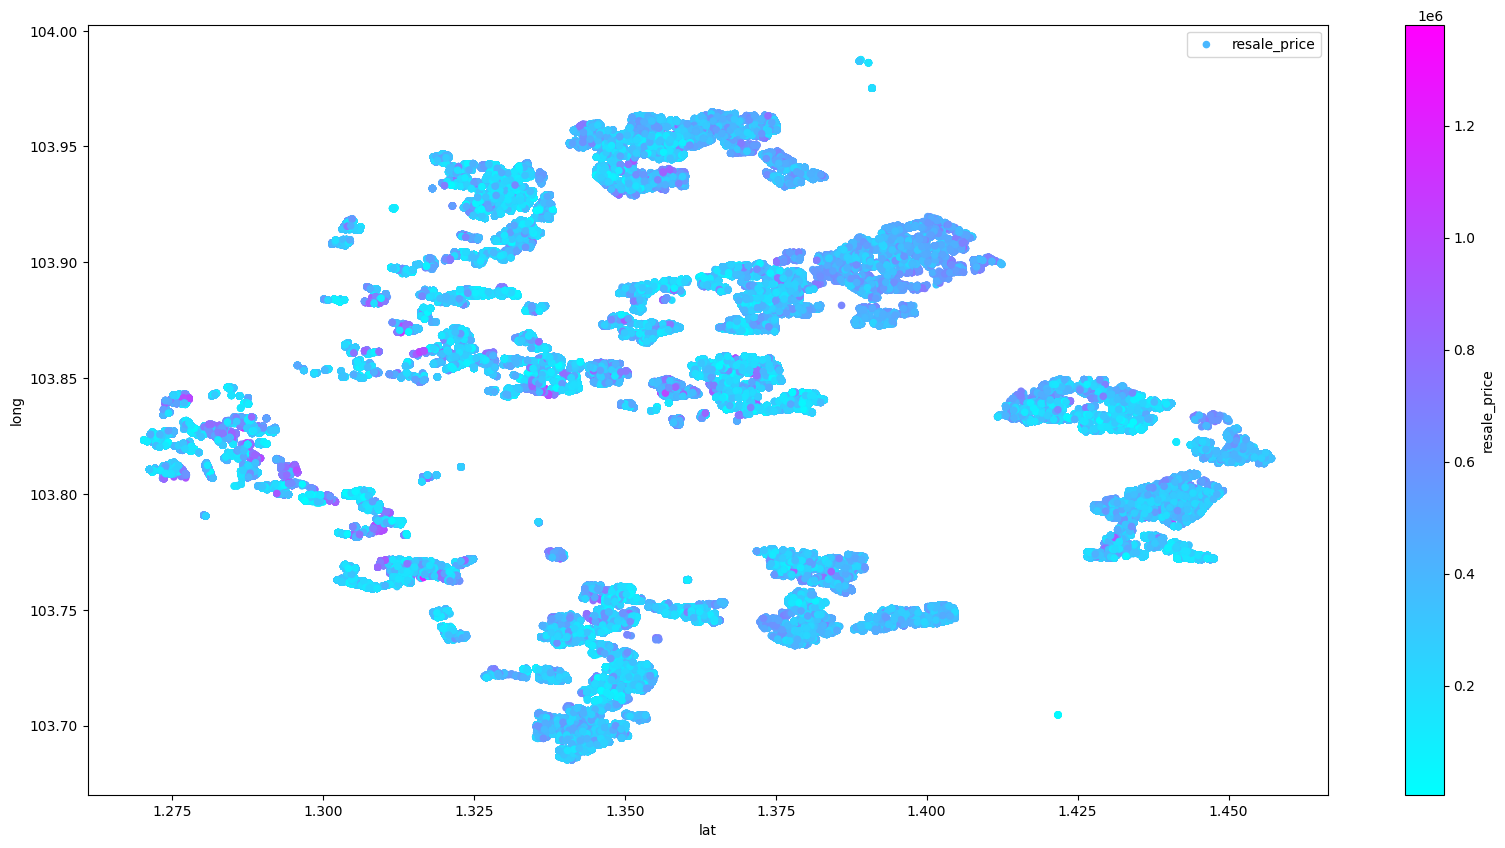

In [ ]:
train_df.plot(kind='scatter', 
                x = 'lat', 
                y= 'long', 
                c ='resale_price', 
                label= 'resale_price', 
                cmap = 'cool',
                colorbar = True,
                figsize = (20,10))
plt.show()

<AxesSubplot: >

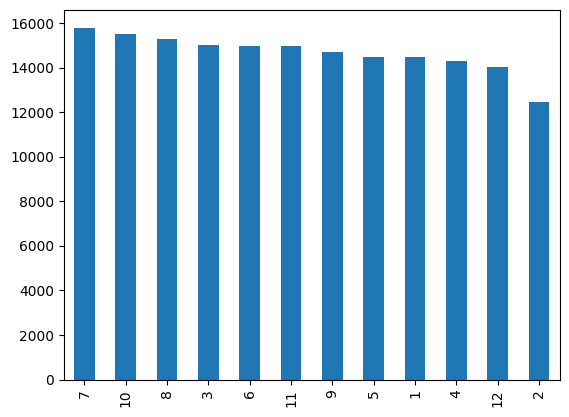

In [ ]:
train_df['month'].value_counts().plot(kind= 'bar')

array([[<AxesSubplot: title={'center': 'floor_area_sqm'}>,
        <AxesSubplot: title={'center': 'resale_price'}>,
        <AxesSubplot: title={'center': 'month'}>],
       [<AxesSubplot: title={'center': 'remaining_lease'}>,
        <AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': 'long'}>],
       [<AxesSubplot: title={'center': 'nearest_distance_to_mrt'}>,
        <AxesSubplot: title={'center': 'year'}>,
        <AxesSubplot: title={'center': 'district'}>]], dtype=object)

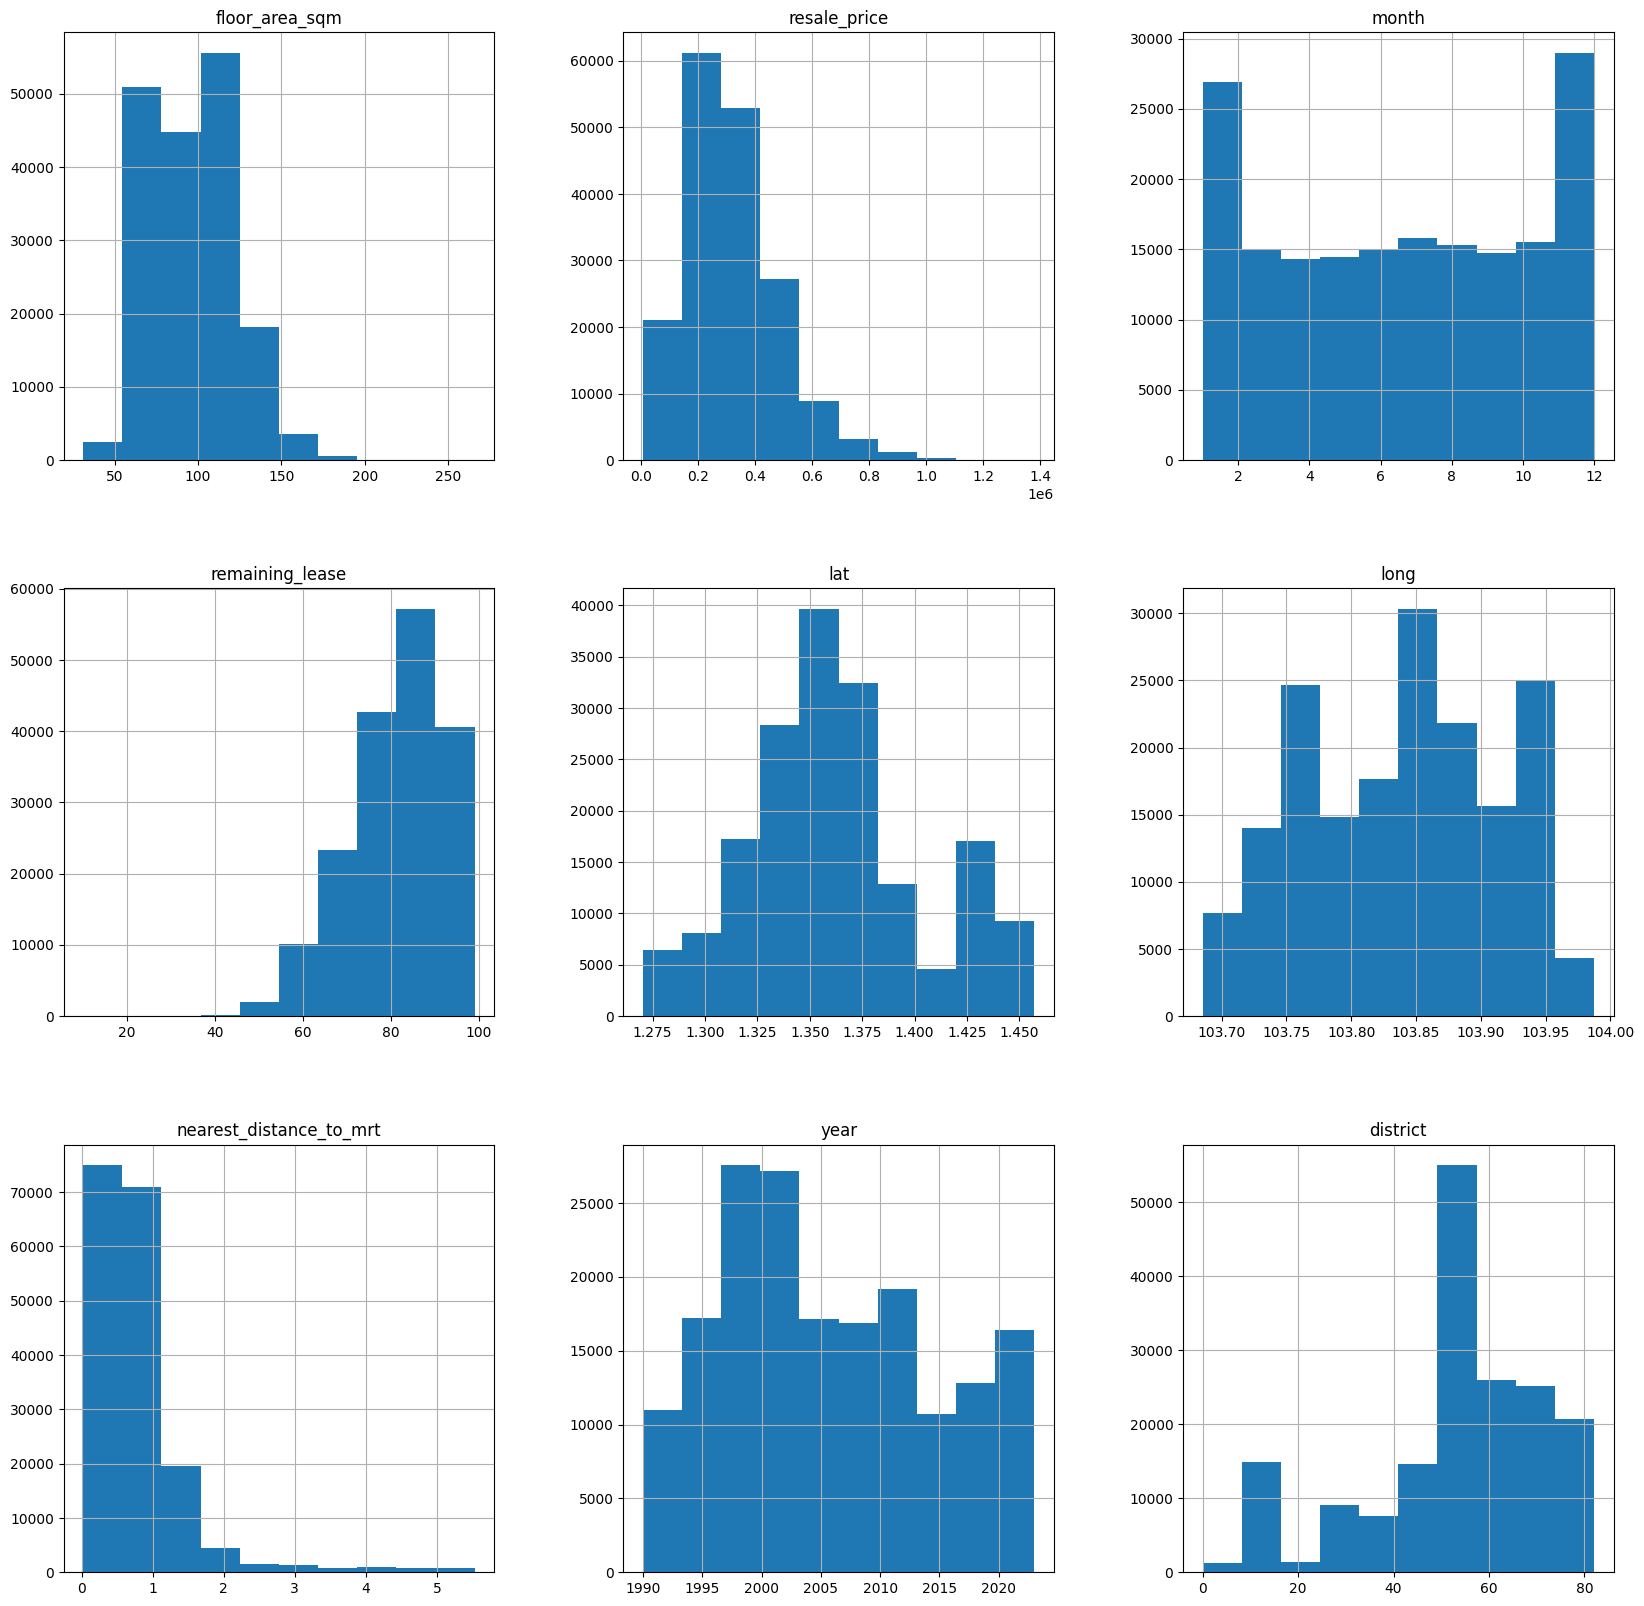

In [ ]:
train_df.hist(figsize=(20,20))

### Storing all of the static values

Basically the end result of the api should allow the user to enter minimal amount of information and allow the api to pick up the rest (since they are able to be inferred or calculated)

In [115]:
df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
0,ANG MO KIO,3 ROOM,Improved,69.0,ANG MO KIO AVE 4,147000.0,2000-01,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
1,ANG MO KIO,3 ROOM,Improved,60.0,ANG MO KIO AVE 4,130000.0,2000-02,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
2,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,105000.0,2000-03,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
3,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,125000.0,2000-05,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
4,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,117000.0,2000-06,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283


In [132]:
# only these values need to be contained. Results post 2000s with distinct town, block, street name, 
# flat type, flat model and floor area sqm
df[~df.duplicated(subset=['town','flat_type','flat_model','floor_area_sqm','address']) & (df.month.str.contains("20"))]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
0,ANG MO KIO,3 ROOM,Improved,69.0,ANG MO KIO AVE 4,147000.0,2000-01,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
1,ANG MO KIO,3 ROOM,Improved,60.0,ANG MO KIO AVE 4,130000.0,2000-02,1986,07 TO 09,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
2,ANG MO KIO,2 ROOM,Improved,45.0,ANG MO KIO AVE 4,105000.0,2000-03,1986,04 TO 06,170,85,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
16,ANG MO KIO,3 ROOM,Improved,61.0,ANG MO KIO AVE 4,114700.0,2001-04,1986,01 TO 03,170,84,170 ANG MO KIO AVE 4,170 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.374001,103.836432,mayflower,0.283
138,ANG MO KIO,3 ROOM,Improved,61.0,ANG MO KIO AVE 4,144000.0,2000-01,1986,04 TO 06,174,85,174 ANG MO KIO AVE 4,174 ANG MO KIO AVENUE 4 KEBUN BARU LINK 1 SING...,1.375097,103.837619,mayflower,0.421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601578,YISHUN,4 ROOM,Model A,93.0,YISHUN AVE 4,600000.0,2023-02,2018,13 TO 15,674B,94 years 10 months,674B YISHUN AVE 4,674B YISHUN AVENUE 4 FERN GROVE @ YISHUN SINGA...,1.421073,103.843117,khatib,1.199
601579,BUKIT BATOK,4 ROOM,Model A,92.0,BT BATOK WEST AVE 8,603000.0,2023-02,2019,10 TO 12,440B,95 years 02 months,440B BT BATOK WEST AVE 8,440B BUKIT BATOK WEST AVENUE 8 WEST RIDGES @ B...,1.355138,103.738218,bukit batok,1.433
601580,PUNGGOL,3 ROOM,Model A,68.0,SUMANG WALK,440000.0,2023-02,2018,10 TO 12,326C,94 years 10 months,326C SUMANG WALK,326C SUMANG WALK PUNGGOL VUE SINGAPORE 823326,1.412405,103.900178,nibong,0.064
601581,TAMPINES,4 ROOM,Model A,92.0,TAMPINES ST 45,660000.0,2023-02,2018,10 TO 12,494J,94 years 10 months,494J TAMPINES ST 45,494J TAMPINES STREET 45 TAMPINES GREENEDGE SIN...,1.363946,103.954621,tampines east,0.862


In [169]:
valid_inputs_df = df[~df.duplicated(subset=['town','flat_type','flat_model','floor_area_sqm','storey_range','address']) & (df.month.str.contains("20"))]

In [168]:
df[(df['street_name']== input['street_name']) & \
    (df['block']== input['block'])]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
284000,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,252000.0,2000-04,1978,10 TO 12,325,77,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284001,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,278000.0,2000-08,1978,01 TO 03,325,77,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284002,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,271000.0,2001-05,1978,01 TO 03,325,76,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284003,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,267000.0,2001-10,1978,04 TO 06,325,76,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284004,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,269000.0,2002-07,1978,01 TO 03,325,75,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741872,ANG MO KIO,4 ROOM,NEW GENERATION,98.0,ANG MO KIO AVE 3,254000.0,1998-12,1978,04 TO 06,325,79,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
741873,ANG MO KIO,4 ROOM,NEW GENERATION,98.0,ANG MO KIO AVE 3,265000.0,1999-04,1978,10 TO 12,325,78,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
741874,ANG MO KIO,4 ROOM,NEW GENERATION,98.0,ANG MO KIO AVE 3,254000.0,1999-07,1978,04 TO 06,325,78,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
741875,ANG MO KIO,4 ROOM,NEW GENERATION,98.0,ANG MO KIO AVE 3,278000.0,1999-10,1978,01 TO 03,325,78,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373


In [139]:
valid_inputs_df.town.unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'GEYLANG', 'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA',
       'CHOA CHU KANG', 'CLEMENTI', 'HOUGANG', 'JURONG EAST', 'YISHUN',
       'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS',
       'QUEENSTOWN', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS',
       'SEMBAWANG', 'SENGKANG', 'PUNGGOL'], dtype=object)

In [164]:
input = {'block': '325',
 'flat_type': '4 ROOM',
 'month': '2023-2',
 'storey_range': '01 TO 03',
 'street_name': 'ANG MO KIO AVE 3'}

In [ ]:
valid_inputs_df

In [170]:
valid_inputs_df[(valid_inputs_df['street_name']== input['street_name']) & \
    (valid_inputs_df['block']== input['block'])]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
284000,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,252000.0,2000-04,1978,10 TO 12,325,77,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284001,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,278000.0,2000-08,1978,01 TO 03,325,77,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284003,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,267000.0,2001-10,1978,04 TO 06,325,76,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284006,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,288000.0,2003-06,1978,07 TO 09,325,74,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373


In [171]:
valid_inputs_df[(valid_inputs_df['street_name']== input['street_name']) & \
        (valid_inputs_df['block']== input['block'])& \
            (valid_inputs_df.flat_type == input['flat_type']) & \
                (valid_inputs_df.storey_range == input['storey_range'])]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt


In [143]:
sorted(valid_inputs_df[valid_inputs_df['town']=='ANG MO KIO']['block'].unique())

['101',
 '102',
 '103',
 '104A',
 '104B',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '124',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '150',
 '151',
 '152',
 '153',
 '154',
 '155',
 '156',
 '157',
 '158',
 '159',
 '163',
 '170',
 '171',
 '172',
 '173',
 '174',
 '175',
 '176',
 '177',
 '178',
 '179',
 '180',
 '181',
 '182',
 '201',
 '202',
 '204',
 '205',
 '207',
 '208',
 '209',
 '210',
 '211',
 '212',
 '213',
 '214',
 '215',
 '216',
 '218',
 '219',
 '220',
 '221',
 '222',
 '223',
 '225',
 '226',
 '226B',
 '226E',
 '226F',
 '229',
 '230',
 '231',
 '232',
 '233',
 '234',
 '235',
 '253',
 '253A',
 '254',
 '255',
 '256',
 '258',
 '259',
 '260A',
 '260B',
 '301',
 '302',
 '303',
 '304',
 '305',
 '306',
 '307A',
 '307B',
 '307C',
 '308A',
 '308B',
 '309A',
 '310A',
 '310B',
 '310C',
 '311',
 '312',
 '313',
 '314',
 '315A',
 '315B',
 '316A',
 '317',
 '319',
 '320',
 '32

In [144]:
valid_inputs_df[(valid_inputs_df['town']=='ANG MO KIO') & (valid_inputs_df['block']=='325')]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
284000,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,252000.0,2000-04,1978,10 TO 12,325,77,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373


In [148]:
df[(df['street_name']=='ANG MO KIO AVE 3') & (df['block']=='325')& (df.month.str.contains("20"))& (df.flat_type == "4 ROOM") & (df.storey_range == "01 TO 03")]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
284001,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,278000.0,2000-08,1978,01 TO 03,325,77,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284002,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,271000.0,2001-05,1978,01 TO 03,325,76,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284004,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,269000.0,2002-07,1978,01 TO 03,325,75,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284011,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,268000.0,2005-12,1978,01 TO 03,325,72,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284017,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,388000.0,2008-06,1978,01 TO 03,325,69,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284026,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,525000.0,2015-08,1978,01 TO 03,325,62,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284029,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,520000.0,2017-06,1978,01 TO 03,325,60 years 03 months,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373
284037,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,435000.0,2020-01,1978,01 TO 03,325,57 years 08 months,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373


In [155]:
test_input_df = valid_inputs_df[(valid_inputs_df['town']=='ANG MO KIO') & (valid_inputs_df['block']=='325')]

In [163]:
test_input_df['flat_type'].values[0]

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,block,remaining_lease,address,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt
284000,ANG MO KIO,4 ROOM,New Generation,98.0,ANG MO KIO AVE 3,252000.0,2000-04,1978,10 TO 12,325,77,325 ANG MO KIO AVE 3,325 ANG MO KIO AVENUE 3 ANG MO KIO 31 SINGAPOR...,1.3679,103.846887,ang mo kio,0.373


### Check if Town is a redunant feature

In [172]:
# Lets see if town is found in the address
# maybe the 1st couple of words?

In [189]:
df.street_name.unique().tolist()

['ANG MO KIO AVE 4',
 'ANG MO KIO AVE 1',
 'ANG MO KIO AVE 10',
 'ANG MO KIO AVE 3',
 'BEDOK NTH RD',
 'ANG MO KIO AVE 5',
 'ANG MO KIO AVE 6',
 'ANG MO KIO AVE 8',
 'ANG MO KIO AVE 9',
 'ANG MO KIO AVE 2',
 'ANG MO KIO ST 21',
 'ANG MO KIO ST 31',
 'ANG MO KIO ST 11',
 'BEDOK RESERVOIR RD',
 'BEDOK NTH ST 3',
 'BEDOK STH AVE 1',
 'BEDOK STH RD',
 'CHAI CHEE AVE',
 'NEW UPP CHANGI RD',
 'CHAI CHEE DR',
 'CHAI CHEE RD',
 'BEDOK NTH AVE 1',
 'BEDOK NTH AVE 2',
 'BEDOK NTH AVE 3',
 'BEDOK NTH AVE 4',
 'BEDOK NTH ST 1',
 'BEDOK NTH ST 2',
 'BEDOK NTH ST 4',
 'BEDOK STH AVE 2',
 'BEDOK STH AVE 3',
 'CHAI CHEE ST',
 'LENGKONG TIGA',
 'JLN TENAGA',
 'SIN MING RD',
 'SHUNFU RD',
 'BISHAN ST 11',
 'BISHAN ST 12',
 'BISHAN ST 13',
 'SIN MING AVE',
 'BISHAN ST 22',
 'BISHAN ST 23',
 'BISHAN ST 24',
 'BRIGHT HILL DR',
 'BT BATOK ST 51',
 'BT BATOK ST 52',
 'BT BATOK ST 11',
 'BT BATOK ST 21',
 'BT BATOK ST 34',
 'BT BATOK WEST AVE 4',
 'BT BATOK WEST AVE 8',
 'BT BATOK EAST AVE 4',
 'BT BATOK EAST

Not a guarantee that knowing the address is enough to 

Q1 : Is there a difference pre and post 2000 say distance between MRTs and or Prices

In [ ]:
post2000_train_df = train_df[train_df['year']>= 2000]
pre2000_train_df = train_df[train_df['year']< 2000]

In [ ]:
train_df['year'].value_counts().agg(['idxmax', 'max'])

idxmax     1999
max       11347
Name: year, dtype: int64

In [ ]:
train_df.groupby('year').agg('count').iloc[:,[1]]

,flat_type
year,
1990,2320
1991,2400
1992,2747
1993,3517
1994,5079
1995,5413
1996,6743
1997,6249
1998,9986


In [ ]:
year_most_transactions = train_df['year'].value_counts().idxmax()

In [ ]:
train_df

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,district
76365,JURONG EAST,4 ROOM,New Generation,103.0,395000.0,3,10 TO 12,59,31 TEBAN GARDENS ROAD SINGAPORE 600031,1.320308,103.738968,jurong east,1.475,2021,60.0
473179,HOUGANG,5 ROOM,Improved,121.0,265000.0,9,01 TO 03,92,964 HOUGANG AVENUE 9 SINGAPORE 530964,1.377158,103.877524,tongkang,1.641,2006,53.0
445613,WOODLANDS,4 ROOM,Model A,101.0,208000.0,7,07 TO 09,95,644 WOODLANDS RING ROAD SINGAPORE 730644,1.436909,103.801599,admiralty,0.415,2002,73.0
817033,WOODLANDS,EXECUTIVE,MAISONETTE,146.0,430000.0,4,04 TO 06,89,804 WOODLANDS STREET 81 SINGAPORE 730804,1.439970,103.787772,woodlands,0.398,1998,73.0
277677,YISHUN,3 ROOM,Model A,74.0,223000.0,9,07 TO 09,73,115 YISHUN RING ROAD CHONG PANG VALE SINGAPORE...,1.434565,103.827974,canberra,0.966,2009,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,KALLANG/WHAMPOA,3 ROOM,Improved,76.0,320000.0,7,13 TO 15,65,16 UPPER BOON KENG ROAD BOON KENG VILLE SINGAP...,1.315432,103.871652,kallang,0.439,2009,38.0
365838,BUKIT MERAH,3 ROOM,New Generation,67.0,158000.0,10,13 TO 15,75,77 TELOK BLANGAH DRIVE DBS TELOK BLANGAH DRIVE...,1.273954,103.808817,telok blangah,0.376,2002,10.0
131932,WOODLANDS,4 ROOM,Model A,105.0,242000.0,9,07 TO 09,95,878 WOODLANDS AVENUE 9 SINGAPORE 730878,1.445433,103.791997,woodlands north,0.770,2000,73.0
671155,TOA PAYOH,3 ROOM,IMPROVED,65.0,203000.0,5,07 TO 09,78,232 LORONG 8 TOA PAYOH PCF SPARKLETOTS PRESCHO...,1.337572,103.858844,toa payoh,1.375,1997,31.0


In [ ]:
train_df[train_df['nearest_distance_to_mrt']>5].groupby('year').agg('count').iloc[:,[1]]

,flat_type
year,
1990,26
1991,44
1992,32
1993,33
1994,58
1995,64
1996,74
1997,108
1998,153


In [ ]:
train_df[train_df['nearest_distance_to_mrt']<5].groupby('year').agg('count').iloc[:,[1]]

,flat_type
year,
1990,2294
1991,2356
1992,2715
1993,3484
1994,5021
1995,5349
1996,6669
1997,6141
1998,9833


In [ ]:
df_combined_geo.select_dtypes(include='object').describe().T

,count,unique,top,freq
town,880195,27,TAMPINES,77728
flat_type,880195,8,4 ROOM,336304
flat_model,880195,34,Model A,180894
street_name,880195,568,YISHUN RING RD,17120
month,880195,398,1999-03,6334
storey_range,880195,25,04 TO 06,221581
block,880195,2658,2,4414
remaining_lease,880195,748,95,26869
address,880195,9576,211 BOON LAY PL,808
full_address,880195,9571,211 BOON LAY PLACE BOON LAY PLACE SINGAPORE 64...,808


In [ ]:
df_combined_geo['flat_model'].unique()

array(['Improved', 'Adjoined flat', 'New Generation', 'Model A',
       'Standard', 'Apartment', 'Maisonette', 'Model A-Maisonette',
       'Simplified', 'Multi Generation', 'Premium Apartment', 'Terrace',
       '2-room', 'Improved-Maisonette', 'Premium Maisonette', 'Model A2',
       'DBSS', 'Type S1', 'Type S2', 'Premium Apartment Loft', '3Gen',
       'NEW GENERATION', 'IMPROVED', 'MODEL A', 'STANDARD', 'SIMPLIFIED',
       'MODEL A-MAISONETTE', 'APARTMENT', 'MAISONETTE', '2-ROOM',
       'TERRACE', 'IMPROVED-MAISONETTE', 'MULTI GENERATION',
       'PREMIUM APARTMENT'], dtype=object)

In [ ]:
df_combined_geo['flat_type'].unique()

array(['3 ROOM', '2 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE',
       'MULTI-GENERATION', '1 ROOM', 'MULTI GENERATION'], dtype=object)

In [ ]:
df_combined_geo['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'GEYLANG', 'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA',
       'CHOA CHU KANG', 'CLEMENTI', 'HOUGANG', 'JURONG EAST', 'YISHUN',
       'JURONG WEST', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS',
       'QUEENSTOWN', 'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS',
       'SEMBAWANG', 'SENGKANG', 'PUNGGOL', 'LIM CHU KANG'], dtype=object)

In [ ]:
df_combined_geo['storey_range'].unique()

array(['07 TO 09', '04 TO 06', '01 TO 03', '10 TO 12', '01 TO 05',
       '06 TO 10', '13 TO 15', '11 TO 15', '22 TO 24', '19 TO 21',
       '16 TO 18', '25 TO 27', '21 TO 25', '16 TO 20', '28 TO 30',
       '26 TO 30', '31 TO 33', '37 TO 39', '34 TO 36', '40 TO 42',
       '31 TO 35', '36 TO 40', '43 TO 45', '46 TO 48', '49 TO 51'],
      dtype=object)

[Text(0, 0, 'JURONG EAST'),
 Text(1, 0, 'HOUGANG'),
 Text(2, 0, 'WOODLANDS'),
 Text(3, 0, 'YISHUN'),
 Text(4, 0, 'SERANGOON'),
 Text(5, 0, 'ANG MO KIO'),
 Text(6, 0, 'CHOA CHU KANG'),
 Text(7, 0, 'PUNGGOL'),
 Text(8, 0, 'QUEENSTOWN'),
 Text(9, 0, 'GEYLANG'),
 Text(10, 0, 'SENGKANG'),
 Text(11, 0, 'PASIR RIS'),
 Text(12, 0, 'TAMPINES'),
 Text(13, 0, 'JURONG WEST'),
 Text(14, 0, 'TOA PAYOH'),
 Text(15, 0, 'BUKIT TIMAH'),
 Text(16, 0, 'KALLANG/WHAMPOA'),
 Text(17, 0, 'BUKIT BATOK'),
 Text(18, 0, 'BISHAN'),
 Text(19, 0, 'BUKIT PANJANG'),
 Text(20, 0, 'BEDOK'),
 Text(21, 0, 'SEMBAWANG'),
 Text(22, 0, 'BUKIT MERAH'),
 Text(23, 0, 'CLEMENTI'),
 Text(24, 0, 'CENTRAL AREA'),
 Text(25, 0, 'MARINE PARADE'),
 Text(26, 0, 'LIM CHU KANG')]

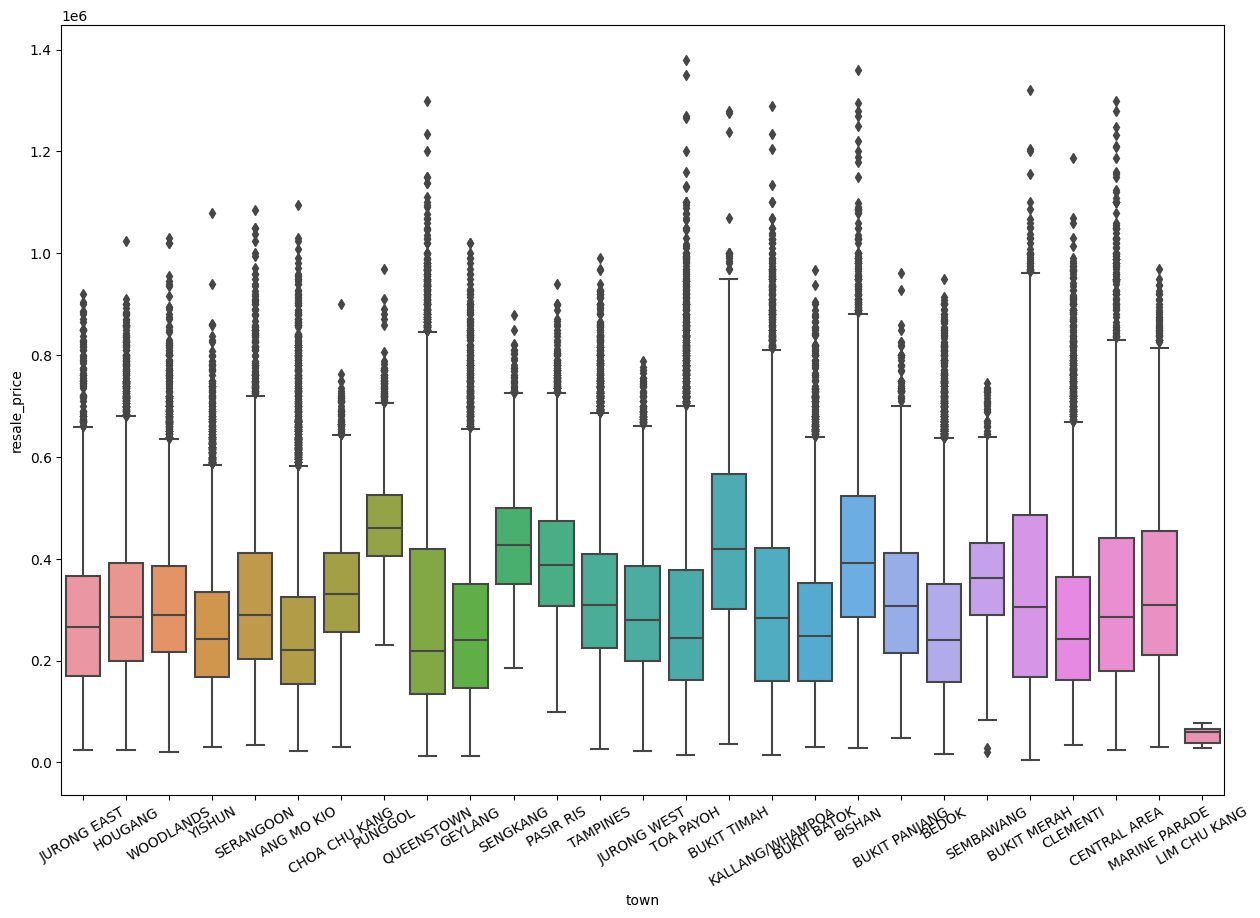

In [ ]:
fig = plt.figure(figsize = (15,10))
ax = sns.boxplot(x='town', y='resale_price', data=train_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Price Trend

In [ ]:
trend_df = round(train_df.groupby('year').aggregate(['mean'])[['floor_area_sqm','resale_price', 'remaining_lease', 'nearest_distance_to_mrt']],2)

C:\Users\Randy\AppData\Local\Temp\ipykernel_9076\1983881809.py:1: FutureWarning: ['town', 'flat_type', 'flat_model', 'storey_range', 'full_address', 'nearest_mrt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  trend_df = round(train_df.groupby('year').aggregate(['mean'])[['floor_area_sqm','resale_price', 'remaining_lease', 'nearest_distance_to_mrt']],2)


In [ ]:
trend_df

,floor_area_sqm,resale_price,remaining_lease,nearest_distance_to_mrt
,mean,mean,mean,mean
year,,,,
1990,85.34,70470.68,88.78,1.05
1991,87.38,75772.70,88.88,1.15
1992,89.05,87085.51,88.21,1.09
1993,92.32,135189.68,87.91,1.13
1994,93.20,175449.92,87.56,1.14
1995,93.49,216260.80,86.96,1.14
1996,92.32,284558.03,86.18,1.18
1997,95.80,310453.96,86.19,1.19


In [ ]:
trend_df['floor_area_sqm'].idxmax().values[0]

2018

In [ ]:
def print_max_min(col:str, max_min:str)->None:
    if max_min == 'max':
        res = f"Year with highest mean {col} : {trend_df[col].idxmax().values[0]} of {trend_df[col].max().values[0]}"
    elif max_min == 'min':
        res = f"Year with lowest mean {col} : {trend_df[col].idxmin().values[0]} of {trend_df[col].min().values[0]}"
    else:
        print('Please either indicate max or min')
    print(res)

In [ ]:
print(f"Year with highest floor_area_sqm : {trend_df['floor_area_sqm'].idxmax().values[0]} of {trend_df['floor_area_sqm'].max().values[0]}")

Year with highest floor_area_sqm : 2018 of 99.35


In [ ]:
for col , _ in trend_df.select_dtypes(exclude='object').columns:
    for metric in ['max', 'min']:
        print_max_min(col, metric)

Year with highest mean floor_area_sqm : 2018 of 99.35
Year with lowest mean floor_area_sqm : 1990 of 85.34
Year with highest mean resale_price : 2022 of 552653.56
Year with lowest mean resale_price : 1990 of 70470.68
Year with highest mean remaining_lease : 1991 of 88.88
Year with lowest mean remaining_lease : 2015 of 73.73
Year with highest mean nearest_distance_to_mrt : 1998 of 1.2
Year with lowest mean nearest_distance_to_mrt : 2021 of 0.59


C:\Users\Randy\AppData\Local\Temp\ipykernel_9076\3635810421.py:1: FutureWarning: ['town', 'flat_type', 'flat_model', 'storey_range', 'full_address', 'nearest_mrt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  train_df.groupby('year').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price Throughout the Years', figsize= (15,10))


([<matplotlib.axis.XTick at 0x1c1812a28b0>,
 [Text(1990, 0, '1990'),
  Text(1991, 0, '1991'),
  Text(1992, 0, '1992'),
  Text(1993, 0, '1993'),
  Text(1994, 0, '1994'),
  Text(1995, 0, '1995'),
  Text(1996, 0, '1996'),
  Text(1997, 0, '1997'),
  Text(1998, 0, '1998'),
  Text(1999, 0, '1999'),
  Text(2000, 0, '2000'),
  Text(2001, 0, '2001'),
  Text(2002, 0, '2002'),
  Text(2003, 0, '2003'),
  Text(2004, 0, '2004'),
  Text(2005, 0, '2005'),
  Text(2006, 0, '2006'),
  Text(2007, 0, '2007'),
  Text(2008, 0, '2008'),
  Text(2009, 0, '2009'),
  Text(2010, 0, '2010'),
  Text(2011, 0, '2011'),
  Text(2012, 0, '2012'),
  Text(2013, 0, '2013'),
  Text(2014, 0, '2014'),
  Text(2015, 0, '2015'),
  Text(2016, 0, '2016'),
  Text(2017, 0, '2017'),
  Text(2018, 0, '2018'),
  Text(2019, 0, '2019'),
  Text(2020, 0, '2020'),
  Text(2021, 0, '2021'),
  Text(2022, 0, '2022')])

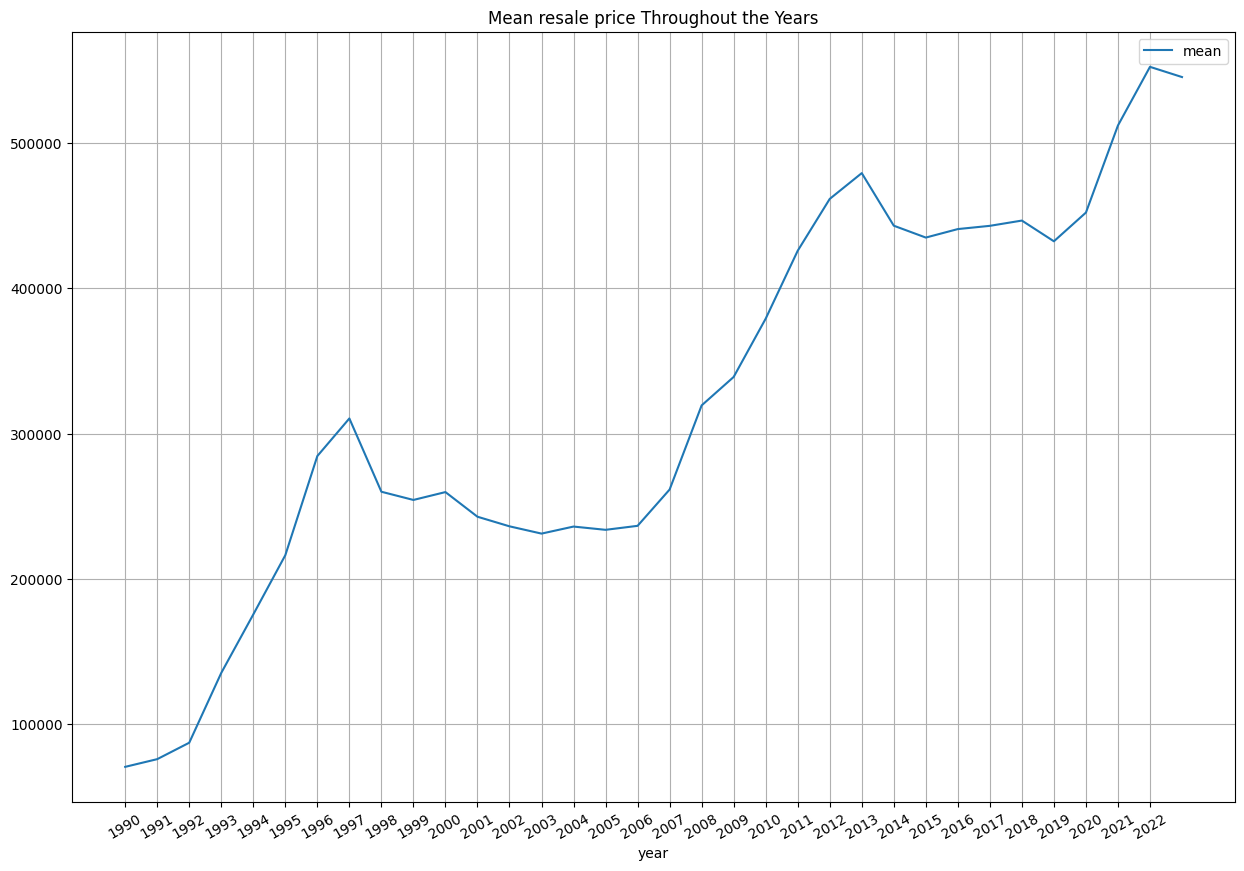

In [ ]:
train_df.groupby('year').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price Throughout the Years', figsize= (15,10))
plt.xticks(range(1990,2023), rotation = 30)

C:\Users\Randy\AppData\Local\Temp\ipykernel_9076\907755644.py:1: FutureWarning: ['town', 'flat_type', 'flat_model', 'storey_range', 'full_address', 'nearest_mrt'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  train_df.groupby('month').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price throughout the months', figsize= (15,10))


([<matplotlib.axis.XTick at 0x1c181673850>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

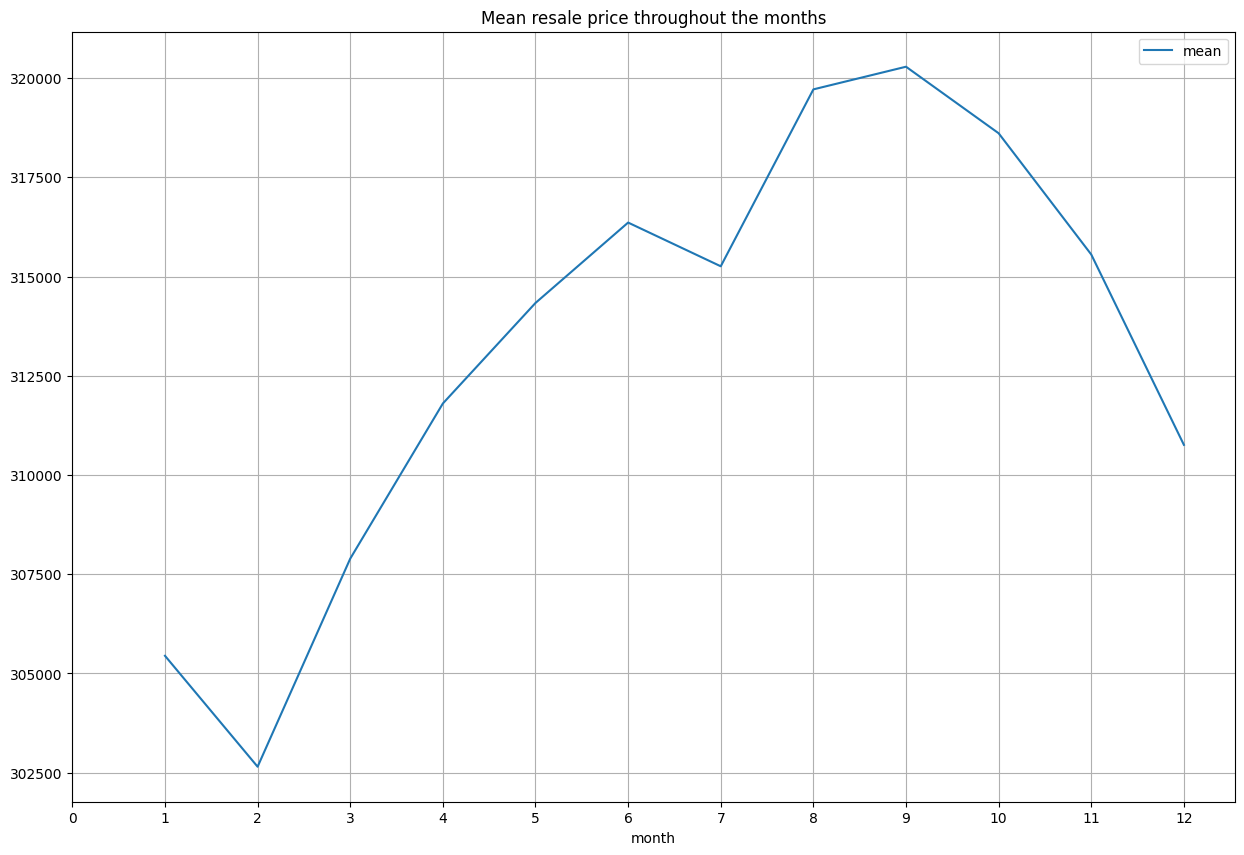

In [ ]:
train_df.groupby('month').aggregate(['mean'])['resale_price'].plot(grid=True, title='Mean resale price throughout the months', figsize= (15,10))
# figure = plt.gcf()
plt.xticks(range(0,13))

# Feature Selection I

In [ ]:
# Pearson's correlation
# Do Clustering 

# Feature selection II:
# PCA, RFE, Lasso, Feature Importance using Random Forest

C:\Users\Randy\AppData\Local\Temp\ipykernel_9076\176757758.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(train_df.corr())
C:\Users\Randy\AppData\Local\Temp\ipykernel_9076\176757758.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True, fmt=".2f", mask=mask)


<AxesSubplot: >

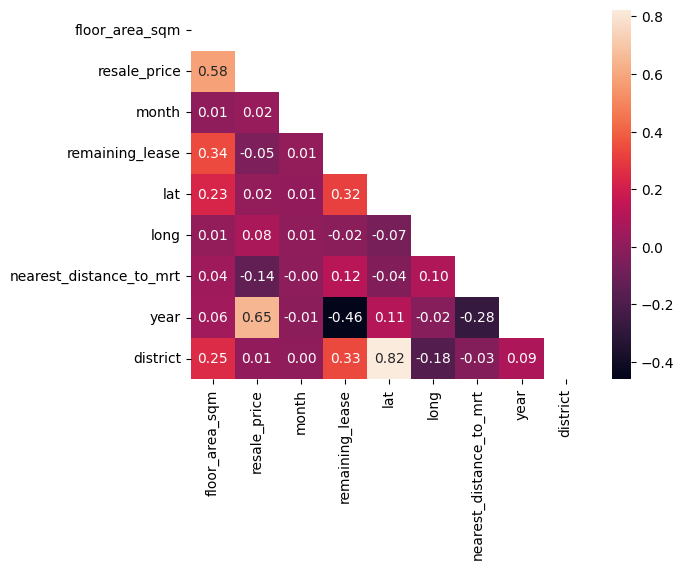

In [ ]:
import seaborn as sns
mask = np.triu(train_df.corr())
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", mask=mask)

I was surprised that the distance to mrt is not a significant factor in affecting the price with the main one being the year it was sold as well as the floor area (which makes sense).

Perhaps it is because for resale markets, there is surviorship bias since only the ones gets sold are recorded here and they are already rather near to the MRT.

We see that district and floor area is correlated, it would be interesting to see which district has the largest floor area. There is also some correlation between the remaining lease and the floor area.

## Clustering

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
dbscan = DBSCAN()
dbscan_ss = DBSCAN()

In [ ]:
train_df.select_dtypes(exclude = 'object')

,floor_area_sqm,resale_price,month,remaining_lease,lat,long,nearest_distance_to_mrt,year,district
76365,103.0,395000.0,3,59,1.320308,103.738968,1.475,2021,60.0
473179,121.0,265000.0,9,92,1.377158,103.877524,1.641,2006,53.0
445613,101.0,208000.0,7,95,1.436909,103.801599,0.415,2002,73.0
817033,146.0,430000.0,4,89,1.439970,103.787772,0.398,1998,73.0
277677,74.0,223000.0,9,73,1.434565,103.827974,0.966,2009,76.0
...,...,...,...,...,...,...,...,...,...
259178,76.0,320000.0,7,65,1.315432,103.871652,0.439,2009,38.0
365838,67.0,158000.0,10,75,1.273954,103.808817,0.376,2002,10.0
131932,105.0,242000.0,9,95,1.445433,103.791997,0.770,2000,73.0
671155,65.0,203000.0,5,78,1.337572,103.858844,1.375,1997,31.0


In [ ]:
train_df_x = train_df.select_dtypes(exclude = 'object').loc[:, train_df.select_dtypes(exclude = 'object').columns != 'resale_price']

In [ ]:
train_df_x.columns

Index(['floor_area_sqm', 'month', 'remaining_lease', 'lat', 'long',
       'nearest_distance_to_mrt', 'year', 'district'],
      dtype='object')

In [ ]:
dbscan.fit(train_df_x)

DBSCAN()

In [ ]:
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 815
Estimated number of noise points: 171319


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
train_df_x_ss = StandardScaler().fit_transform(train_df_x)

In [ ]:
dbscan_ss.fit(train_df_x_ss)

DBSCAN()

In [ ]:
labels = dbscan_ss.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 579
Estimated number of noise points: 8975


In [ ]:
# Running PCA to reduce the number of dimensions before running clustering

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=0.95)
pca_ss = PCA(n_components=0.95)

In [ ]:
train_df_x_pca = pca.fit_transform(train_df_x)
train_df_x_ss_pca = pca_ss.fit_transform(train_df_x_ss)

## PCA Components

In [ ]:
train_df_x_ss_pd = pd.DataFrame(train_df_x_ss, columns=train_df_x.columns)

In [ ]:
pca_ss.fit(train_df_x_ss_pd)

PCA(n_components=0.95)

In [ ]:
pd.DataFrame(list(zip(["pca " + str(idx) for idx in range(1,len(pca_ss.explained_variance_ratio_))] ,pca_ss.explained_variance_ratio_)), columns=['PCA', 'Explained Variance'])

,PCA,Explained Variance
0,pca 1,0.277612
1,pca 2,0.196045
2,pca 3,0.127657
3,pca 4,0.124882
4,pca 5,0.109497
5,pca 6,0.101062


In [ ]:
np.sum(pca_ss.components_[0])

-1.8024962441787873

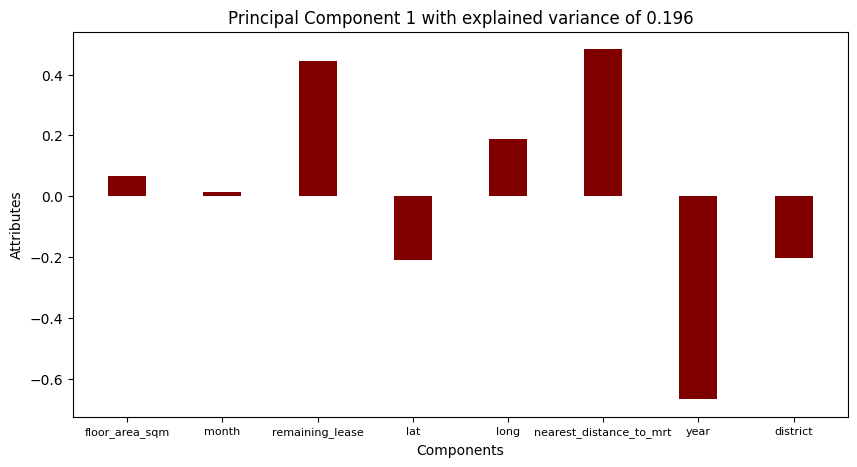

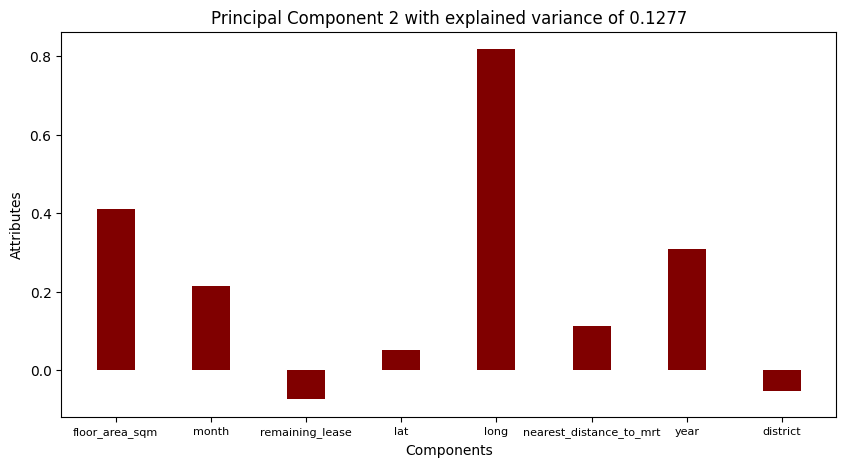

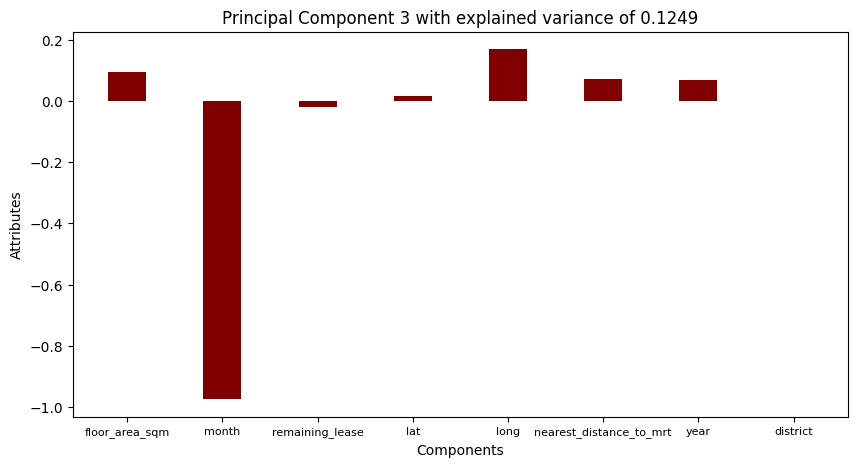

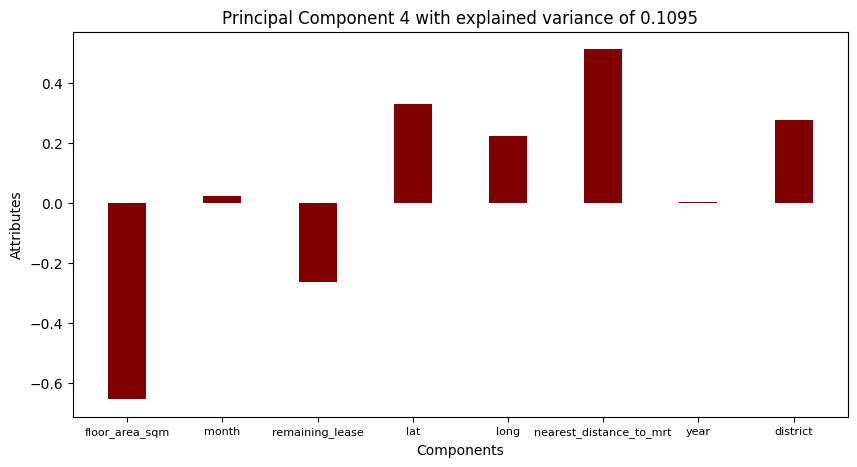

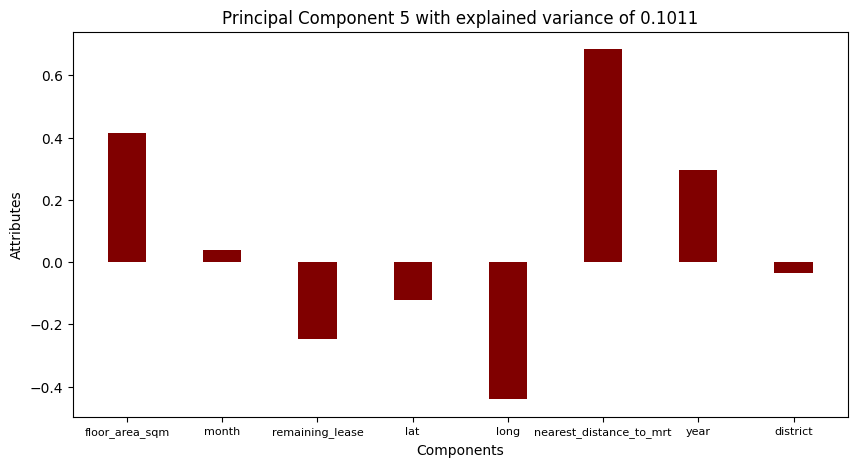

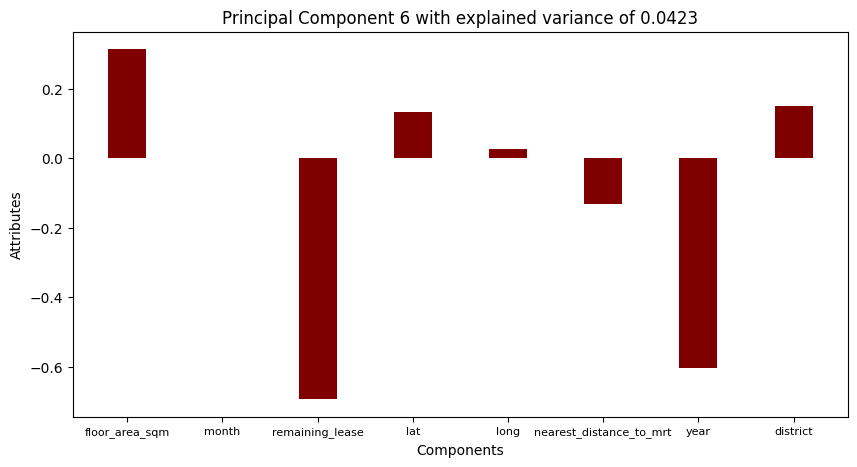

In [ ]:
for idx in range(1,len(pca_ss.explained_variance_ratio_)):
    fig = plt.figure(figsize = (10, 5))
    plt.bar(pca_ss.feature_names_in_, pca_ss.components_[idx], width = 0.4, color = 'maroon')
    plt.xlabel("Components")
    plt.xticks(size = 8)
    plt.ylabel("Attributes")
    plt.title(f"Principal Component {idx} with explained variance of {round(pca_ss.explained_variance_ratio_[idx],4)}")
    plt.show()

PCA tells us where the variation of the data comes from.

The combined 6 principle components (PC) inform us 95% of the variance in the dataset, out of which the 1st 2 PC only informs us approximately 35% of the variance in the dataset

In [ ]:
dbscan_pca = DBSCAN()
dbscan_ss_pca = DBSCAN()

In [ ]:
dbscan_pca.fit(train_df_x_pca)
dbscan_ss_pca.fit(train_df_x_ss_pca)

DBSCAN()

In [ ]:
labels = dbscan_pca.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 9048
Estimated number of noise points: 76239


In [ ]:
labels = dbscan_ss_pca.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 467
Estimated number of noise points: 7370


In [ ]:
# took 23 minutes
# for eps in [0.5,1,1.5,2.0]:
#     dbscan = DBSCAN(eps = eps)
#     dbscan.fit(train_df_x_ss_pca)

#     labels = dbscan.labels_

#     # Number of clusters in labels, ignoring noise if present.
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise_ = list(labels).count(-1)
    
#     print(f"Fitted: eps: {eps} in DBSCAN")
#     print("Estimated number of clusters: %d" % n_clusters_)
#     print("Estimated number of noise points: %d" % n_noise_)

Seems like eps 1 or 1.5 is good with 15 and 3 clusters respectively

In [ ]:
dbscan = DBSCAN(eps = 1.5)
dbscan.fit(train_df_x_ss_pca)
train_df['dbscan_label']= dbscan.labels_

In [ ]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2], dtype=int64)

In [ ]:
train_df

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,district,dbscan_label
76365,JURONG EAST,4 ROOM,New Generation,103.0,395000.0,3,10 TO 12,59,31 TEBAN GARDENS ROAD SINGAPORE 600031,1.320308,103.738968,jurong east,1.475,2021,60.0,0
473179,HOUGANG,5 ROOM,Improved,121.0,265000.0,9,01 TO 03,92,964 HOUGANG AVENUE 9 SINGAPORE 530964,1.377158,103.877524,tongkang,1.641,2006,53.0,0
445613,WOODLANDS,4 ROOM,Model A,101.0,208000.0,7,07 TO 09,95,644 WOODLANDS RING ROAD SINGAPORE 730644,1.436909,103.801599,admiralty,0.415,2002,73.0,0
817033,WOODLANDS,EXECUTIVE,MAISONETTE,146.0,430000.0,4,04 TO 06,89,804 WOODLANDS STREET 81 SINGAPORE 730804,1.439970,103.787772,woodlands,0.398,1998,73.0,0
277677,YISHUN,3 ROOM,Model A,74.0,223000.0,9,07 TO 09,73,115 YISHUN RING ROAD CHONG PANG VALE SINGAPORE...,1.434565,103.827974,canberra,0.966,2009,76.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,KALLANG/WHAMPOA,3 ROOM,Improved,76.0,320000.0,7,13 TO 15,65,16 UPPER BOON KENG ROAD BOON KENG VILLE SINGAP...,1.315432,103.871652,kallang,0.439,2009,38.0,0
365838,BUKIT MERAH,3 ROOM,New Generation,67.0,158000.0,10,13 TO 15,75,77 TELOK BLANGAH DRIVE DBS TELOK BLANGAH DRIVE...,1.273954,103.808817,telok blangah,0.376,2002,10.0,0
131932,WOODLANDS,4 ROOM,Model A,105.0,242000.0,9,07 TO 09,95,878 WOODLANDS AVENUE 9 SINGAPORE 730878,1.445433,103.791997,woodlands north,0.770,2000,73.0,0
671155,TOA PAYOH,3 ROOM,IMPROVED,65.0,203000.0,5,07 TO 09,78,232 LORONG 8 TOA PAYOH PCF SPARKLETOTS PRESCHO...,1.337572,103.858844,toa payoh,1.375,1997,31.0,0


In [ ]:
train, test = train_test_split(train_df, test_size = TEST_SIZE)

In [ ]:
# # whole dataset took 20 mins
# train_df_smaller = train_df.sample(int(len(train_df)/100), random_state =SEED)
# # sns.pairplot(train_df_smaller, hue = 'dbscan_label', palette = 'bwr', diag_kind="hist" , plot_kws ={'alpha':0.5})#, markers=["o", "s"])
# sns.pairplot(train_df, hue = 'dbscan_label', palette = 'bwr', diag_kind="hist", plot_kws ={'alpha':0.5} )#, markers=["o", "s"])

In [ ]:
print(len(train_df[train_df['dbscan_label']== -1]))

20


In [ ]:
train_df[train_df['dbscan_label']== -1]

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,district,dbscan_label
813045,KALLANG/WHAMPOA,3 ROOM,TERRACE,261.0,485000.0,2,01 TO 03,75,54 JALAN MA'MOR SINGAPORE 320054,1.328255,103.856286,toa payoh,1.091,1996,32.0,-1
308208,QUEENSTOWN,EXECUTIVE,Maisonette,192.0,890000.0,7,22 TO 24,82,81 STRATHMORE AVENUE SINGAPORE 141081,1.294620,103.809277,queenstown,0.356,2010,14.0,-1
853162,WOODLANDS,EXECUTIVE,APARTMENT,177.0,405000.0,9,04 TO 06,10,847 WOODLANDS STREET 82 SINGAPORE 730847,1.442153,103.791733,woodlands,0.865,1994,73.0,-1
386729,KALLANG/WHAMPOA,3 ROOM,Terrace,266.0,1020000.0,4,01 TO 03,58,65 JALAN MA'MOR SINGAPORE 320065,1.328204,103.857971,boon keng,1.064,2013,32.0,-1
777244,LIM CHU KANG,3 ROOM,IMPROVED,66.0,55000.0,7,01 TO 03,85,4 LIM CHU KANG ROAD SINGAPORE 710004,1.421752,103.704579,yew tee,5.469,1994,71.0,-1
777247,LIM CHU KANG,3 ROOM,IMPROVED,59.0,63500.0,11,01 TO 03,85,4 LIM CHU KANG ROAD SINGAPORE 710004,1.421752,103.704579,yew tee,5.469,1994,71.0,-1
849549,TAMPINES,EXECUTIVE,APARTMENT,147.0,356000.0,5,04 TO 06,10,332 TAMPINES STREET 32 SINGAPORE 520332,1.353168,103.960689,simei,1.375,1994,52.0,-1
777264,LIM CHU KANG,3 ROOM,IMPROVED,59.0,67000.0,12,01 TO 03,81,4 LIM CHU KANG ROAD SINGAPORE 710004,1.421752,103.704579,yew tee,5.469,1998,71.0,-1
517909,ANG MO KIO,4 ROOM,Model A,95.0,323000.0,9,16 TO 18,10,309A ANG MO KIO STREET 31 TECK GHEE VISTA SING...,1.365029,103.845301,ang mo kio,0.722,2005,56.0,-1
716675,HOUGANG,3 ROOM,MODEL A,74.0,148000.0,12,04 TO 06,85,210 HOUGANG STREET 21,1.359464,103.886861,ang mo kio,4.307,1998,0.0,-1


(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.,
        1200000., 1400000., 1600000.]),
 [Text(0.0, 0, '0'),
  Text(200000.0, 0, '200000'),
  Text(400000.0, 0, '400000'),
  Text(600000.0, 0, '600000'),
  Text(800000.0, 0, '800000'),
  Text(1000000.0, 0, '1000000'),
  Text(1200000.0, 0, '1200000'),
  Text(1400000.0, 0, '1400000'),
  Text(1600000.0, 0, '1600000')])

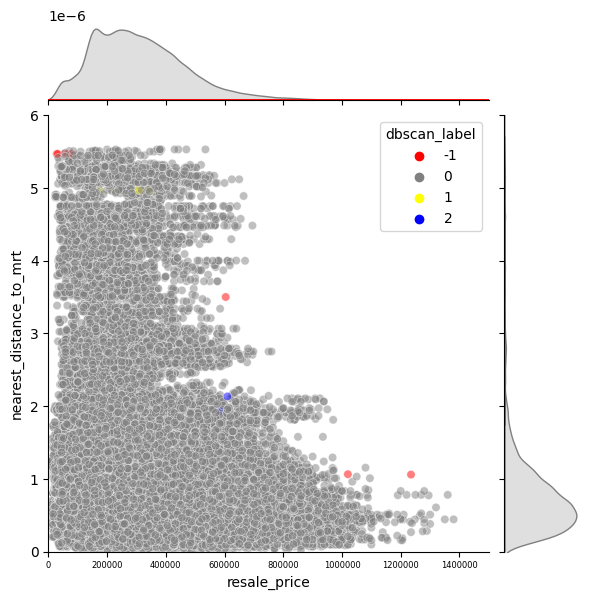

In [ ]:
sns.jointplot(
    train_df,
    x='resale_price', 
    y='nearest_distance_to_mrt', 
    hue='dbscan_label',
    joint_kws={'alpha':0.5}, 
    palette=['red','gray','yellow','blue'], 
    marginal_ticks = False,
    xlim = (0,1500000),
    ylim = (0,6) );
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(size = 6)

Lets try 15 clusters with eps = 1

In [ ]:
dbscan = DBSCAN(eps = 1.0)
dbscan.fit(train_df_x_ss_pca)
train_df['dbscan_label']= dbscan.labels_

In [ ]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [ ]:
# # whole dataset took 14 mins
# train_df_smaller = train_df.sample(int(len(train_df)/100), random_state =SEED)
# # sns.pairplot(train_df_smaller, hue = 'dbscan_label', palette = 'bwr', diag_kind="hist" , plot_kws ={'alpha':0.5})#, markers=["o", "s"])
# sns.pairplot(train_df, hue = 'dbscan_label', palette = 'bwr', diag_kind="hist", plot_kws ={'alpha':0.5} )#, markers=["o", "s"])

In [ ]:
# sns.jointplot(
#     train_df,
#     x='resale_price', 
#     y='floor_area_sqm', 
#     hue='dbscan_label',
#     joint_kws={'alpha':0.2}, 
#     palette = 'rainbow',
#     # palette=['red','gray','yellow','blue'], 
#     marginal_ticks = False,
#     xlim = (0,1500000),
#     ylim = (0,300));
# plt.ticklabel_format(style='plain', axis='x')
# plt.xticks(size = 6)

In [ ]:
train_df.head()

,town,flat_type,flat_model,floor_area_sqm,resale_price,month,storey_range,remaining_lease,full_address,lat,long,nearest_mrt,nearest_distance_to_mrt,year,district,dbscan_label
76365,JURONG EAST,4 ROOM,New Generation,103.0,395000.0,3,10 TO 12,59,31 TEBAN GARDENS ROAD SINGAPORE 600031,1.320308,103.738968,jurong east,1.475,2021,60.0,0
473179,HOUGANG,5 ROOM,Improved,121.0,265000.0,9,01 TO 03,92,964 HOUGANG AVENUE 9 SINGAPORE 530964,1.377158,103.877524,tongkang,1.641,2006,53.0,0
445613,WOODLANDS,4 ROOM,Model A,101.0,208000.0,7,07 TO 09,95,644 WOODLANDS RING ROAD SINGAPORE 730644,1.436909,103.801599,admiralty,0.415,2002,73.0,0
817033,WOODLANDS,EXECUTIVE,MAISONETTE,146.0,430000.0,4,04 TO 06,89,804 WOODLANDS STREET 81 SINGAPORE 730804,1.439970,103.787772,woodlands,0.398,1998,73.0,0
277677,YISHUN,3 ROOM,Model A,74.0,223000.0,9,07 TO 09,73,115 YISHUN RING ROAD CHONG PANG VALE SINGAPORE...,1.434565,103.827974,canberra,0.966,2009,76.0,0
